In [121]:
import numpy as np
import os
import glob
import sys
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
import argparse
import csv

#
# Implements the HORUS probabilistic WiFi Localization system
# ( Mobile and Sensor Networks course - University of Oxford )
# April 2016
#

def init():
    print("")
    print ('*' * 60)
    print (' The Horus Localization System')
    print (" Sensor Networks Course - University of Oxford")
    print ('*' * 60)
    print ("")
    print ("")
    return


# Function to load the wifi RSS data
def load_wifi_data(data_folder, n_samples, n_ap):
    """
    :param data_folder: Location of WiFi RSS data
    :param n_samples: Number of RSS samples collected for each location
    :param n_ap: Number of access points
    :return: train and test wifi databases
    """
    current_location = os.getcwd()
    sys.stdout.write("-> Loading files...")

    train_path = data_folder + "/" + "wifiData/"
    test_path = data_folder + "/" + "testWifiData/"

    # We are going to examine two cases with 3 and 5 Access Points (APs)
    if n_ap == 3:
        ap_index = [1, 2, 3]
    else:
        ap_index = [1, 2, 3, 4, 5]

    # We read the wifi RSS collected in the training phase to built the Wifi database
    os.chdir(train_path)
    train_files = glob.glob("*.txt")
    n_locations = len(train_files)
    wifi_database = np.zeros((n_locations, (n_ap * n_samples) + 3))
    ap_name = "AP_"

    file_count = -1
    for f in train_files:
        file_count += 1

        if n_ap == 3:
            ap_counter = [0, 0, 0]
        else:
            ap_counter = [0, 0, 0, 0, 0]

        fid = open(f, 'r')
        wifi_database[file_count, 0] = file_count
        first_line = 0
        for line in fid:
            data = line.split()
            if first_line == 0:
                first_line += 1
                wifi_database[file_count, 1] = int(data[0])
                wifi_database[file_count, 2] = int(data[1])
            else:
                for idx in range(1, n_ap + 1):
                    if data[1] == (ap_name + str(idx)):
                        ap_counter[idx - 1] += 1
                        db_index = int((n_samples * (ap_index[idx - 1] - 1)) + 2 + ap_counter[idx - 1])
                        wifi_database[file_count, db_index] = float(data[2])
    os.chdir("../..")

    # Now we load the test points. Wifi data collected at unknown locations.
    os.chdir(test_path)
    test_files = glob.glob("*.txt")
    test_files.sort()
    n_locations = len(test_files)
    test_db = np.zeros((n_locations, (n_ap * (n_samples - 10)) + 3))

    file_count = -1
    for f in test_files:
        file_count += 1

        if n_ap == 3:
            ap_counter = [0, 0, 0]
        else:
            ap_counter = [0, 0, 0, 0, 0]

        fid = open(f, 'r')
        test_db[file_count, 0] = file_count
        first_line = 0
        for line in fid:
            data = line.split()
            if first_line == 0:
                first_line += 1
                test_db[file_count, 1] = int(data[0])
                test_db[file_count, 2] = int(data[1])
            else:
                for idx in range(1, n_ap + 1):
                    if data[1] == (ap_name + str(idx)):
                        ap_counter[idx - 1] += 1
                        db_index = int(((n_samples - 10) * (ap_index[idx - 1] - 1)) + 2 + ap_counter[idx - 1])
                        test_db[file_count, db_index] = float(data[2])

    sys.stdout.write("done\n")
    
    os.chdir(current_location)
    return wifi_database, test_db


# Visualize fingerprint locations and locations of APs
def show_fingerprints(train_db, n_ap):
    """
    :param train_db: RSS points collected at known locations
    :param n_ap: Number of APs
    :return: null
    """
    sys.stdout.write("-> Displaying fingerprints...")

    if n_ap == 3:
        ap_loc = np.array([[6, 6], [8, 16], [18, 14]])
    else:
        ap_loc = np.array([[6, 6], [8, 16], [18, 14], [16, 4], [12, 10]])

    plt.figure()
    plt.plot(train_db[:, 1], train_db[:, 2], 'co', markersize=17)
    plt.plot(ap_loc[:, 0], ap_loc[:, 1], 'b*', markersize=10)
    major_ticks = np.arange(-2, 22, 2)
    axes = plt.gca()
    axes.set_xlim([-2, 22])
    axes.set_ylim([-2, 22])
    axes.set_xticks(major_ticks)
    axes.set_yticks(major_ticks)
    plt.grid(True)
    plt.xlabel("X -> m")
    plt.ylabel("Y -> m")
    plt.title("Cyan points: fingerprint locations, Blue points: Access Points")
    plt.show(block=False)
    sys.stdout.write("done\n")

    return


# Fit a normal distribution to the RSS data
def fit_data(train_db, n_samples, n_ap):
    """
    :param train_db: RSS points collected at known locations
    :param n_samples: Number of RSS samples per location
    :param n_ap: Number of access points
    :return: Wifi fingerprint database; We approximate the RSS at each location with a Gaussian
    """

    sys.stdout.write("-> Modeling RSS with Gaussian dist...")

    n_loc = len(train_db)

    # Initialize Wifi database
    wifi_db = np.zeros((n_loc, 3 + (n_ap * 2)))

    for i in range(0, n_loc):
        wifi_db[i, 0] = i
        wifi_db[i, 1] = train_db[i, 1]
        wifi_db[i, 2] = train_db[i, 2]
        for j in range(0, n_ap):
            ind_start = int((n_samples * j) + 3)
            ind_end = int((j + 1) * n_samples + 3)
            dat = train_db[i, ind_start:ind_end]
            [mu, sigma] = norm.fit(dat)
            wifi_db[i, (j * 2) + 3] = mu
            wifi_db[i, (j * 2) + 4] = sigma

    sys.stdout.write("done\n")
    return wifi_db


# Plot Wifi RSS histogram per location - Fit a  Gaussian Dist to the data
def plot_histogram(train_db, location, n_ap, n_samples):
    """
    :param train_db: RSS points collected at known locations
    :param location: Location to plot the RSS histogram
    :param n_ap: Number of access points
    :param n_samples: Number of RSS samples per location
    :return: null
    """

    sys.stdout.write("-> Visualizing histograms...")

    if (location < 0) or (location >= len(train_db)):
        location = 0

    # Extract the RSS data from :param location
    for i in range(0, n_ap):
        ind_start = int((n_samples * i) + 3)
        ind_end = int((i + 1) * n_samples + 3)
        dat = train_db[location, ind_start:ind_end]

        # Plot the RSS histogram
        plt.figure()
        n_bins = int(round(np.sqrt(len(dat))))
        plt.hist(dat, bins=n_bins, normed=True, alpha=0.6, color='g')

        # Approximate the histogram with a Gaussian distribution
        [mu, sigma] = norm.fit(dat)
        x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 500)
        y = norm.pdf(x, mu, sigma)
        plt.plot(x, y, 'r-', linewidth=2)
        plt.xlabel('Wifi RSS -> dBm')
        plt.ylabel('Frequency')
        plt.title('RSS histogram of AP=%d , Norm(%.2f,%.2f)' % (i + 1, mu, sigma))
        plt.grid(True)
        plt.show(block=False)

    sys.stdout.write("done\n")
    return


# The Horus probabilistic localization system
def predict(wifi_db, test_db,n_ap, samples_array):
    """
    :param wifi_db: The Wifi database
    :param test_db: Wifi RSS points an the unknown locations
    :param n_ap: Number of APs
    :param n_samples: Samples per location
    :return: The estimated locations
    """

    
    sys.stdout.write("-> Running Horus...")

    predicted_loc = np.zeros((len(test_db), 2))
    actual_loc = test_db[:, 1:3]

    small_val = 7
    # - - - - WRITE YOUR CODE HERE - - - - -

    
    AP=np.zeros((n_ap,wifi_db.shape[0],2))
    for i in range(n_ap):
        AP[i,:,:]= wifi_db[:,(2*i+3):(2*i+5)]
    
    for i in range(test_db.shape[0]):
        
        loss = np.zeros(AP.shape[1])
        
        for j in range(AP.shape[1]):
            
            lossall = [log_loss(test_db[i,samples_array[:k].sum()+3:samples_array[:k+1].sum()+3].mean(),AP[k,j,0],AP[k,j,1]) for k in range(n_ap)] 
            loss[j] = sum(lossall)/sum(~np.isnan(lossall))         
        
        #print(np.argmax(loss))
        loss = np.exp(loss)
        
        loss = loss/loss.sum()
        
        
        #new_x = (wifi_db[:,1]*loss).sum()
        #new_y = (wifi_db[:,2]*loss).sum()
        thresh = sorted(loss)[-small_val]
        loss[loss<thresh] = 0
        
        loss = loss/loss.sum()
        new_x = (wifi_db[:,1]*loss).sum()
        new_y = (wifi_db[:,2]*loss).sum()
        
        
        
        
        
    
        
        
        #result = np.argmax(loss)
        #predicted_loc[i,:] = wifi_db[result,1:3]
        predicted_loc[i,:] = np.array([new_x,new_y])
    
    # - - - - - - - - - - - - - - - - - - - -

    sys.stdout.write("done\n")
    return actual_loc, predicted_loc

# Plot the actual and estimated locations
def plot_path(actual_loc, predicted_loc, n_ap):
    """
    :param actual_loc: Actual locations
    :param predicted_loc: Estimated locations
    :param n_ap: Number of APs
    :return: null
    """
    sys.stdout.write("-> Visualizing estimated trajectory...")

    if n_ap == 3:
        ap_loc = np.array([[6, 6], [8, 16], [18, 14]])
    else:
        ap_loc = np.array([[6, 6], [8, 16], [18, 14], [16, 4], [12, 10]])

    plt.figure()
    plt.plot(ap_loc[:, 0], ap_loc[:, 1], 'b*', markersize=15)
    plt.plot(actual_loc[:, 0], actual_loc[:, 1], 'go-', linewidth=2)
    plt.plot(predicted_loc[:, 0], predicted_loc[:, 1], 'ro-', linewidth=2)

    major_ticks = np.arange(-2, 22, 2)

    axes = plt.gca()
    axes.set_xlim([-2, 22])
    axes.set_ylim([-2, 22])
    axes.set_xticks(major_ticks)
    axes.set_yticks(major_ticks)
    plt.xlabel('X -> m')
    plt.ylabel('Y -> m')
    plt.title('Green line = actual path , Red line = estimated path, Blue points = AP loc')
    plt.grid(True)
    plt.savefig('main_img.pdf',bbox_inches='tight')

    plt.show(block=False)

    
    sys.stdout.write("done\n")
    return


# Calculate and plot the localization error
def plot_error(actual_loc, predicted_loc):
    """
    :param actual_loc: Actual locations
    :param predicted_loc: Estimated Locations
    :return: null
    """

    sys.stdout.write("-> Calculating localization error...")

    err = np.zeros((1, len(actual_loc)))
    for i in range(0, len(actual_loc)):
        err[0, i] = np.sqrt((actual_loc[i, 0] - predicted_loc[i, 0]) ** 2 +
                            (actual_loc[i, 1] - predicted_loc[i, 1]) ** 2)

    mean_err = np.mean(err)

    ecdf = ECDF(err[0, :])
    plt.figure()
    plt.plot(ecdf.x, ecdf.y)
    plt.grid(True)
    plt.xlabel('error -> m')
    plt.ylabel('Probability')
    plt.title('Error CDF , Mean error = %.3f' % mean_err)
    plt.show(block=False)

    sys.stdout.write("done\n")
    return


def log_loss(val,mu,sigma):
    #log_loss = (-(val-mu)**2)/(sigma**2)
    
    return np.log(norm.pdf(val,mu,sigma))

In [122]:
os.chdir('/Users/shaan/Desktop/sensornetworks/')


************************************************************
 The Horus Localization System
 Sensor Networks Course - University of Oxford
************************************************************


-> Loading files...done
-> Visualizing histograms...

/Users/shaan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


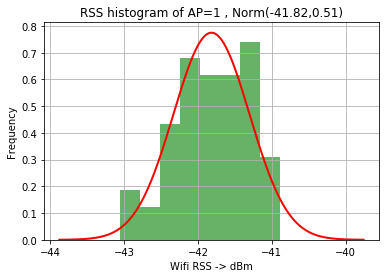

/Users/shaan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


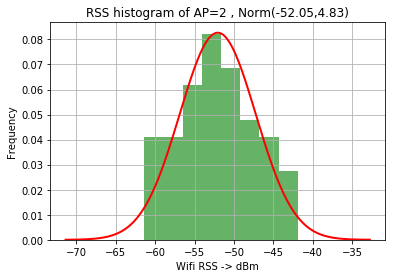

/Users/shaan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


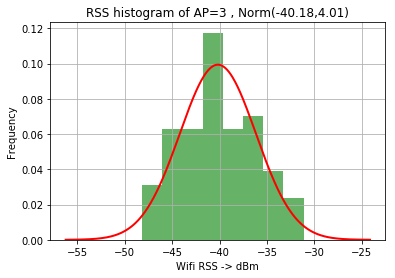

/Users/shaan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


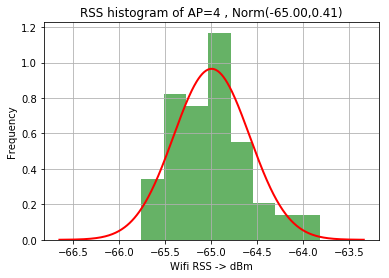

/Users/shaan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


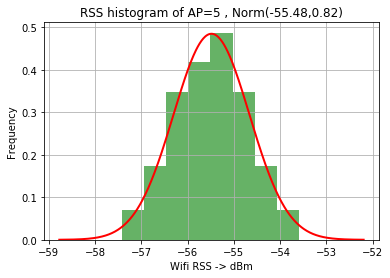

done
-> Modeling RSS with Gaussian dist...done
-> Running Horus...

/Users/shaan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:360: RuntimeWarning: divide by zero encountered in log


done
-> Visualizing estimated trajectory...

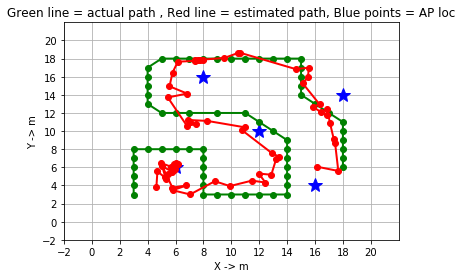

done
-> Calculating localization error...

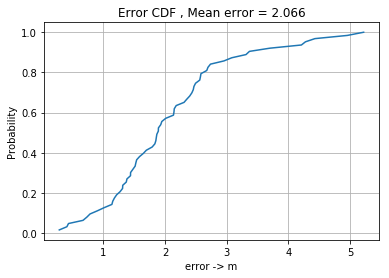

done


In [123]:
# --------------------------------------------------------------
# MAIN CODE
# --------------------------------------------------------------

# ----- Constants -----
# Number of measurements per location
nSamples = 60

# ---- Configure Parameters -----
# Select Dataset (set1 or set2)
#parser = argparse.ArgumentParser()
#parser.add_argument('-s','--data_set', choices={"set1", "set2"}, type=str, 
#    default='set1')
#args = parser.parse_args()
data_set = 'set2'

# Visualize the RSS in location = loc
loc = 2

# ----- Run System ------

# set1 contains 3 access points and set2 5 access points
if data_set == "set1":
    nAP = 3
else:
    nAP = 5

init()

# Load the RSS measurements from file
(trainDB, testDB) = load_wifi_data(data_set, nSamples, nAP)

# Show fingerprint locations
#show_fingerprints(trainDB, nAP)

# Plot the RSS histogram and approximate it with a Gaussian
plot_histogram(trainDB, loc, nAP, nSamples)

# Fit Gaussian distribution to the RSS measurements
wifiDB = fit_data(trainDB, nSamples, nAP)

# Run the localization algorithm
# Estimate the unknown location given RSS measurements at that location
(actualLoc, predictedLoc) = predict(wifiDB, testDB,3, np.array([50,50,50]))

# Visualize the actual and estimated locations
plot_path(actualLoc, predictedLoc, nAP)
# Plot the mean localization error and error CDF
plot_error(actualLoc, predictedLoc)



-> Visualizing estimated trajectory...

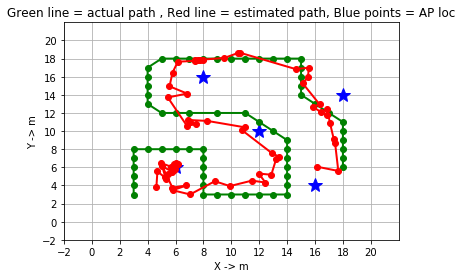

done


In [105]:
plot_path(actualLoc, np.array(predictedLoc), nAP)
